In [1]:
# 获取股票数据代码
import baostock as bs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date

In [16]:
# 登陆系统
lg = bs.login()
code = 'sh.600276' 
start = '2022-07-01'
end = '2023-07-01'

login success!


In [17]:
# 获取指数基金指数历史数据

hs300_price = bs.query_history_k_data_plus(code, "date,code,open,high,low,close,preclose,pctChg",
              start_date=start, end_date=end, frequency="d")
# 整合为DataFrame格式
data_list = []
while (hs300_price.error_code == '0') & hs300_price.next():
    data_list.append(hs300_price.get_row_data())
hs300 = pd.DataFrame(data_list, columns=hs300_price.fields)
hs300.to_csv('600276.csv')

In [18]:
df = pd.read_csv('600276.csv')

In [19]:
df

,Unnamed: 0,date,code,open,high,low,close,preclose,pctChg
0,0,2022-07-01,sh.600276,37.09,39.00,36.86,38.94,37.09,4.9879
1,1,2022-07-04,sh.600276,39.00,41.50,37.81,41.17,38.94,5.7268
2,2,2022-07-05,sh.600276,40.59,41.16,39.83,40.51,41.01,-1.2192
3,3,2022-07-06,sh.600276,40.61,41.59,39.15,39.42,40.51,-2.6907
4,4,2022-07-07,sh.600276,39.03,39.40,38.01,38.65,39.42,-1.9533
...,...,...,...,...,...,...,...,...,...
238,238,2023-06-26,sh.600276,46.28,47.08,45.68,46.36,46.40,-0.0862
239,239,2023-06-27,sh.600276,46.18,46.80,45.83,45.95,46.36,-0.8844
240,240,2023-06-28,sh.600276,46.13,46.40,45.71,46.20,45.95,0.5441
241,241,2023-06-29,sh.600276,46.15,47.44,46.10,47.05,46.20,1.8398


In [20]:
price = df["close"]

相对强弱指标（RSI）

In [21]:
def calculate_rsi(prices, period=14):
    deltas = np.diff(prices)
    seed = deltas[:period + 1]
    up = seed[seed >= 0].sum() / period
    down = -seed[seed < 0].sum() / period
    rs = up / down
    rsi = np.zeros_like(prices)
    rsi[:period] = 100. - 100. / (1. + rs)

    for i in range(period, len(prices)):
        delta = deltas[i - 1]  # since the diff is 1 shorter
        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up * (period - 1) + upval) / period
        down = (down * (period - 1) + downval) / period
        rs = up / down
        rsi[i] = 100. - 100. / (1. + rs)

    return rsi

# 示例用法
import numpy as np

# 假设这是你的价格数据，这里使用一个随机生成的示例数据
prices = np.array(price)

rsi_values = calculate_rsi(prices)
print(rsi_values)


[50.25380711 50.25380711 50.25380711 50.25380711 50.25380711 50.25380711
 50.25380711 50.25380711 50.25380711 50.25380711 50.25380711 50.25380711
 50.25380711 50.25380711 53.15602402 54.41944095 51.81099611 42.14644207
 42.44674098 41.93879628 38.82154881 38.40407904 34.81234988 37.99843581
 48.82644227 54.45214002 54.6959379  50.97409129 48.71924831 51.51042074
 51.55937593 48.70008435 46.39126251 47.46416687 44.33225562 43.59712895
 39.287393   37.34574957 36.6947457  40.7468504  39.57020293 36.76392935
 34.06582011 42.1489687  40.42389529 38.11399877 37.2288527  38.58416021
 36.06817607 38.92734032 47.73717257 52.89444458 53.95249458 52.44600958
 47.48588237 46.481658   42.60079244 38.29650892 34.1080538  36.83891636
 31.79818303 45.45444271 44.468154   53.51930439 54.2157932  49.09647151
 48.16358083 43.4411519  51.25294162 65.12585388 69.37056722 68.84991136
 66.11843112 66.67556154 69.07875947 62.95202327 58.1289376  63.70100209
 63.70100209 59.2967407  63.68612303 67.57255713 68

当RSI值超过70时，可能意味着市场超买，当RSI值低于30时，可能意味着市场超卖。这些信号可能会指导您进行买入或卖出出的决策。

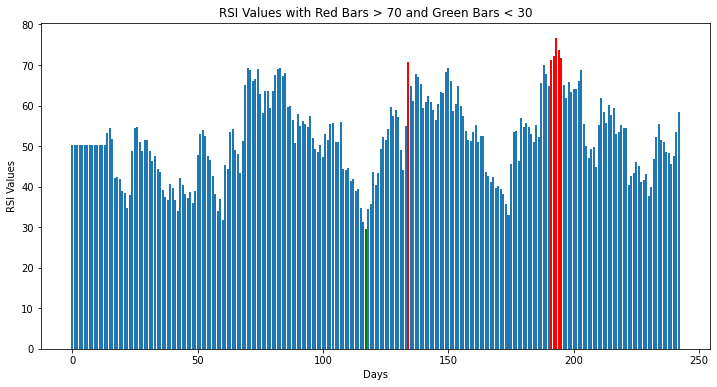

In [26]:
plt.figure(figsize=(12, 6))
plt.bar(range(len(rsi_values)), rsi_values)

# 设置柱形颜色
for i in range(len(rsi_values)):
    if rsi_values[i] > 70:
        plt.gca().get_children()[i].set_facecolor('red')
    elif rsi_values[i] < 30:
        plt.gca().get_children()[i].set_facecolor('green')

plt.xlabel('Days')
plt.ylabel('RSI Values')
plt.title('RSI Values with Red Bars > 70 and Green Bars < 30')
plt.show()

MACD

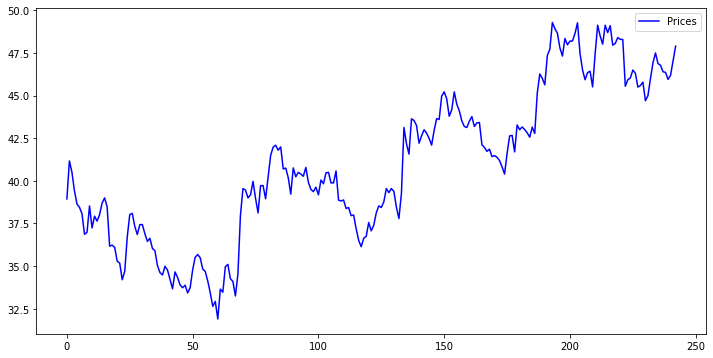

In [24]:
import numpy as np

def calculate_ema(data, window):
    # 计算指数移动平均线
    weights = np.exp(np.linspace(-1., 0., window))
    weights /= weights.sum()
    ema = np.convolve(data, weights, mode='full')[:len(data)]
    ema[:window] = ema[window]
    return ema

def calculate_macd(prices, short_window=12, long_window=26, signal_window=9):
    # 计算MACD指标
    short_ema = calculate_ema(prices, short_window)
    long_ema = calculate_ema(prices, long_window)

    dif = short_ema - long_ema
    signal_line = calculate_ema(dif, signal_window)

    macd_histogram = dif - signal_line

    return dif, signal_line, macd_histogram

# 示例用法
import matplotlib.pyplot as plt

# 假设这是你的价格数据，这里使用一个随机生成的示例数据
prices = price

dif, signal_line, macd_histogram = calculate_macd(prices)

plt.figure(figsize=(12, 6))
plt.plot(prices, label='Prices', color='blue')
plt.legend()
plt.show()


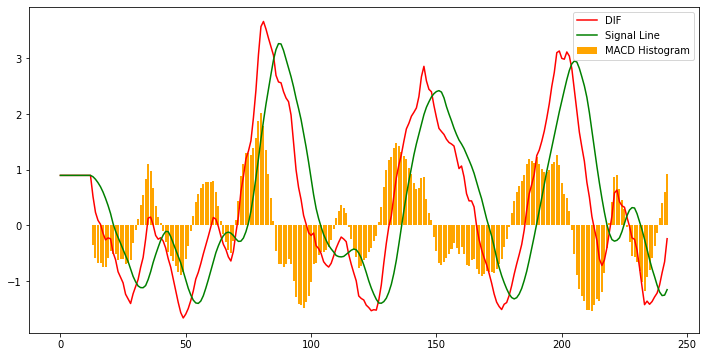

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(dif, label='DIF', color='red')
plt.plot(signal_line, label='Signal Line', color='green')
plt.bar(range(len(prices)), macd_histogram, label='MACD Histogram', color='orange')
plt.legend()
plt.show()

计算了 MACD 指标的三个部分：DIF 线、信号线和 MACD 柱状线。然后，我们使用 Matplotlib 相当于上述的价格数据以及 MACD 指标的曲线和柱状图。

20均线

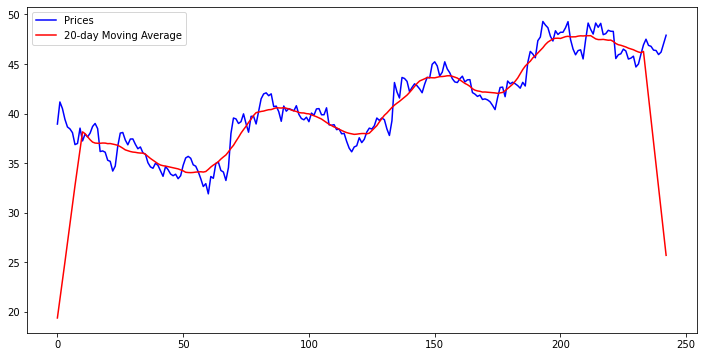

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_moving_average(prices, window=20):
    # 计算移动平均线
    return np.convolve(prices, np.ones(window)/window, mode='same')

# 示例用法
# 假设这是你的价格数据，这里使用一个随机生成的示例数据
prices = price

# 计算20日均线
ma_20 = calculate_moving_average(prices, window=20)

# 绘制价格曲线和20日均线曲线
plt.figure(figsize=(12, 6))
plt.plot(prices, label='Prices', color='blue')
plt.plot(ma_20, label='20-day Moving Average', color='red')
plt.legend()
plt.show()
